In [48]:
from bigml.api import BigML
from pandas import DataFrame
import matplotlib.pyplot as plt

In [49]:
# Connexion au projet via l'API de BIG ML

api = BigML('MAXIMEFAVOT', '69757fb108f0bd7a8678e0b66e3de66ae6478c81', project='project/5dc023dcfb7bdd2dcf000374')

In [8]:
# Creation des sources sur BigML

source_train = api.create_source('https://oml-data.s3.amazonaws.com/kaggle-give-me-credit-train.csv')

In [9]:
# On crée un dataset à partir de la source puis on split (Val et Test)

train_full = api.create_dataset(source_train, {"name": "Train Full"})
val_set = api.create_dataset(train_full, {"name": "Val_set", "sample_rate": 0.8, "seed": "my seed"})
test_set = api.create_dataset(train_full, {"name": "Test_set", "sample_rate": 0.8 , "seed": "my seed", "out_of_bag": True})

In [53]:
# creation des listes vides pour contenir l'abscisse (taille du dataset) et l'ordonnée (AUC) pour le modele ensemble et deepnet

x_ensemble = []
y_ensemble = []
x_deepnet = []
y_deepnet = []

for i in range(1,11): # On fait une boucle pour faire varier de 10 à 100 % de lignes du dataset Val_set
   
    # On crée le nouveau dataset de train à partir du dataset de train initial
    train_set = api.create_dataset(val_set, {"name": "Train Set " + str(i/10), "sample_rate": i/10, "seed": "my seed"})
    api.ok(val_set)   
   
    # On crée le modèle (ensemble) à partir du train_set
    ensemble = api.create_ensemble(train_set, {"objective_field" : "SeriousDlqin2yrs", "name": "Ensemble " + str(i/10)})
    api.ok(ensemble)
   
    # On évalue le modèle ensemble (avec le test_set)
    evaluation = api.create_evaluation(ensemble, test_set)
    api.ok(evaluation)
   
    # On crée le modèle (deepnet) à partir du train_set
    deepnet = api.create_deepnet(train_set, {"objective_field" : "SeriousDlqin2yrs", "name": "Deepnet " + str(i/10)})
    api.ok(deepnet)
   
    # On évalue le modèle deepnet (avec le test_set)
    evaluation_deepnet = api.create_evaluation(deepnet, test_set)
    api.ok(evaluation_deepnet)

    # On stocke dans une liste la valeur de l'axe des abscisses (graph_x) et la valeur de l'AUC (graph_y) à partir de la donnée BigML
    x_ensemble.append(i*10)
    y_ensemble.append(evaluation['object']['result']['model']['per_class_statistics'][1]['area_under_roc_curve'])
    
    x_deepnet.append(i*10)
    y_deepnet.append(evaluation['object']['result']['model']['per_class_statistics'][1]['area_under_roc_curve'])
    
    # On itere de 1 le compteur i et on recommence la boucle
    i += 1 

# On imprime les resultats
    
print(x_ensemble)
print(y_ensemble)
print(x_deepnet)
print(y_deepnet)

KeyboardInterrupt: 

In [58]:
from joblib import dump

eval_maxime = [x_ensemble, y_ensemble, y_deepnet]

dump(eval_maxime, 'eval_maxime.joblib')

['eval_maxime.joblib']

In [64]:
from joblib import load
eval_christophe = load('eval_christophe.joblib')
eval_laurent = load('eval_laurent.joblib')
eval_maud = load('eval_maud.joblib')
eval_maxime = load('eval_maxime.joblib')

In [65]:
# Methode Christophe

df=DataFrame(eval_christophe[0])
df['y_ensemble_christophe']=eval_christophe[1]
df['y_ensemble_maxime']=eval_maxime[1]
df['y_ensemble_laurent']=eval_laurent[1]
df['y_ensemble_maud']=eval_maud[1]

df2=DataFrame(eval_christophe[1])
df2['y_ensemble_maxime']=eval_maxime[1]
df2['y_ensemble_laurent']=eval_laurent[1]
df2['y_ensemble_maud']=eval_maud[1]

df['ensemble_moyenne']=df2.mean(axis=1)

df['y_deepnet_christophe']=eval_christophe[2]
df['y_deepnet_maxime']=eval_maxime[2]
df['y_deepnet_laurent']=eval_laurent[2]
df['y_deepnet_maud']=eval_maud[2]

df3=DataFrame(eval_christophe[2])
df3['y_ensemble_maxime']=eval_maxime[2]
df3['y_ensemble_laurent']=eval_laurent[2]
df3['y_ensemble_maud']=eval_maud[2]


df['ensemble_deepnet']=df3.mean(axis=1)

ValueError: Length of values does not match length of index

In [60]:
# Methode 2

#on creer des listes vides

y_ensemble = []
y_deepnet = []

y_ensemble_mean = []
y_deepnet_mean = []

i=0

# on itere dans la colonne [1] ou [2] les lignes de 1 à 10
for i in range(10): 
    
    y_ensemble = (eval_christophe[1][i] + eval_maxime[1][i] + eval_laurent[1][i] + eval_maud[1][i])/4
    
    y_deepnet = (eval_christophe[2][i] + eval_maxime[2][i] + eval_laurent[2][i] + eval_maud[2][i])/4
    
# On insert les moyennes dans les listes de moyennes
    
    y_ensemble_mean.append(y_ensemble)
    
    y_deepnet_mean.append(y_deepnet)
    
print(y_deepnet_mean)
print(y_ensemble_mean)
print(x_ensemble)

IndexError: list index out of range

In [57]:
mean_lmcm = DataFrame({'y_ensemble_mean': y_ensemble_mean, 'y_deepnet_mean': y_deepnet_mean},
                      index = eval_maud[0])

mean_lmcm

ValueError: Empty data passed with indices specified.

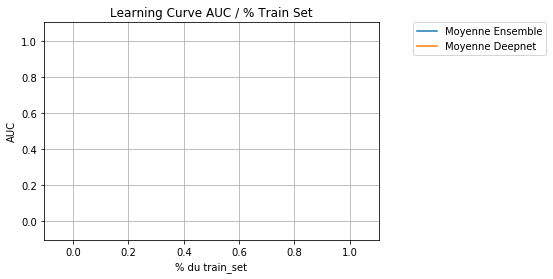

In [62]:
fig, ax = plt.subplots()
ax.plot(x_ensemble, y_ensemble_mean, label='Moyenne Ensemble')
ax.plot(x_deepnet, y_deepnet_mean, label='Moyenne Deepnet')
ax.set(xlabel='% du train_set', ylabel='AUC',  title='Learning Curve AUC / % Train Set')
plt.legend(bbox_to_anchor=(1.5, 1), loc='best', borderaxespad=0.)
ax.grid()
plt.show()